# How ClimaX model works

## Table of Contents

* [ClimaX & Satellite image time series](#ClimaX-&-Satellite-image-time-series)
* [Prepare training data for satellite image time series](#Prepare-training-data-for-satellite-image-time-series)
* [Architecture](#Architecture)
  * [Variable-tokenization](#Variable-tokenization)
  * [Variable-aggregation](#Variable-aggregation)
* [Implementation in arcgis.learn](#Implementation-in-arcgis.learn) 
* [References](#References)

## ClimaX & Satellite image time series

Earth observation time series is referred to as collection of satellite images of a location from different time-periods, stacked vertically resulting in a 3-dimensional structure. The collection has a common projection and a consistent timeline. Each location in the space-time is a vector of values across a timeline as shown in figure 1:

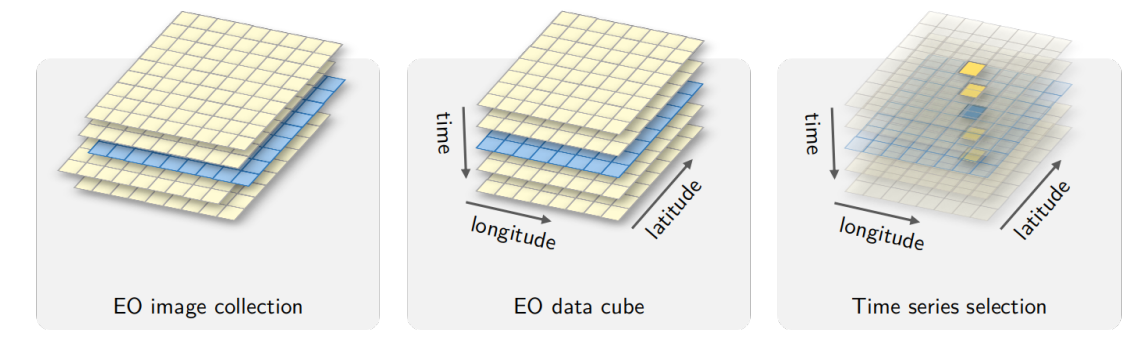

<center> Figure 1. Time-series of satellite imagery </center>

ClimaX is a ViT based deep learning model developed using diverse datasets that cover various weather variables across different spatial and temporal resolutions. The author demonstrated that this foundational model can be fine-tuned for a broad range of climate and weather applications, including tasks involving atmospheric variables and spatio-temporal details not encountered during the pretraining phase.

This approach leverages the understanding that weather and climate predictions are rooted in physical phenomena and their interactions with geography. Traditional numerical models, while effective, require extensive computational resources. In contrast, advancements in remote sensing have provided vast amounts of geospatial data that could enhance modeling at finer resolutions, but current models struggle to integrate this data. Machine learning offers an alternative by scaling both data and compute, showing promise in weather forecasting. By integrating diverse data sources, they have aimed to develop physics-informed foundational models that can better capture the complexities of weather and climate systems.

In this guide, we will focus on how to use `ClimaX` available in `arcgis.learn`, a flexible and generalizable deep learning model  for weather and climate science [Nguyen et al.](https://proceedings.mlr.press/v202/nguyen23a/nguyen23a.pdf)

## Prepare training data for satellite image time series

The [Export Training Data for Deep Learning](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) tool is used to export training data for the model. The input satellite time-series is a [multi-dimensional raster](https://pro.arcgis.com/en/pro-app/latest/help/data/imagery/an-overview-of-multidimensional-raster-data.htm) from the required time periods or time steps. Here are the [steps](https://www.youtube.com/watch?v=HFbTFTnsMWM), to create multi-dimensional raster from collection of images. Shown below is the structure of a multi-dimensional raster. 

<figure style="text-align: center;">
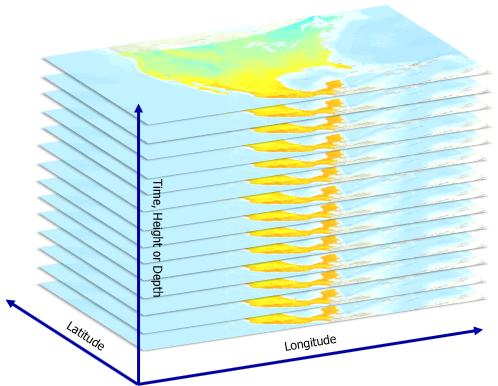
<figcaption style="text-align: center; margin-top: 20px;"> Figure 2. multi-dimensional dataset </figcaption>
</figure>

The [Export Training Data for Deep Learning](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) tool is used to export training data for the model. The input satellite time-series is a [multi-dimensional raster](https://pro.arcgis.com/en/pro-app/latest/help/data/imagery/an-overview-of-multidimensional-raster-data.htm) with multiple or single variable from the required time periods or time steps. The rows and columns of the raster should be divisible i.e 240 x 120, 360 x 180, so chips are exported in chips of equals sizes without padding like 120 x 120 chips, 180 x 180 chips respectively . Here are the [steps](https://www.youtube.com/watch?v=HFbTFTnsMWM), to create multi-dimensional raster from collection of images.

The model supports training on multiple variables. The multidimensional raster is provided as input with `Export Tiles` as metadata format in the `Export Training Data For Deep Learning` tool. The tool is available in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) and [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image-server).

The expected export folder structure is:

- output path to
    - folder with variables
     - variable_name_1
       - exported data 
     - variable_name_2 
       - exported data
      ......
     - variable_name_n
       - exported data

For example, if we have available monthly sea surface temperature (SST) of shape 360x180, we will combine the monthly SST .nc files into one multidimensional raster (.crf) using the [Merge Multidimensional Rasters](https://pro.arcgis.com/en/pro-app/latest/tool-reference/multidimension/merge-multidimensional-rasters.htm) tool. After the merging of nc files, it is advised to reproject the map and resultant multi-dimensional raster into `Behrmann (world)` coordinate system. After its done, the raster can be provided as an `Input Raster` to the model. Below are the used parameters used in export tool.

- `Input Raster`: SST_1980_to_2015.crf
- `Output Folder`: 'output\path\to\sst'
- `Tile Size X & Tile Size Y`: 180, 180
- `Stride X & Stride Y`: 180, 180
- `Meta Data Format`: 'Export Tiles'
- `Environments`: Set `Cell Size` and `Processing Extent` as per input raster

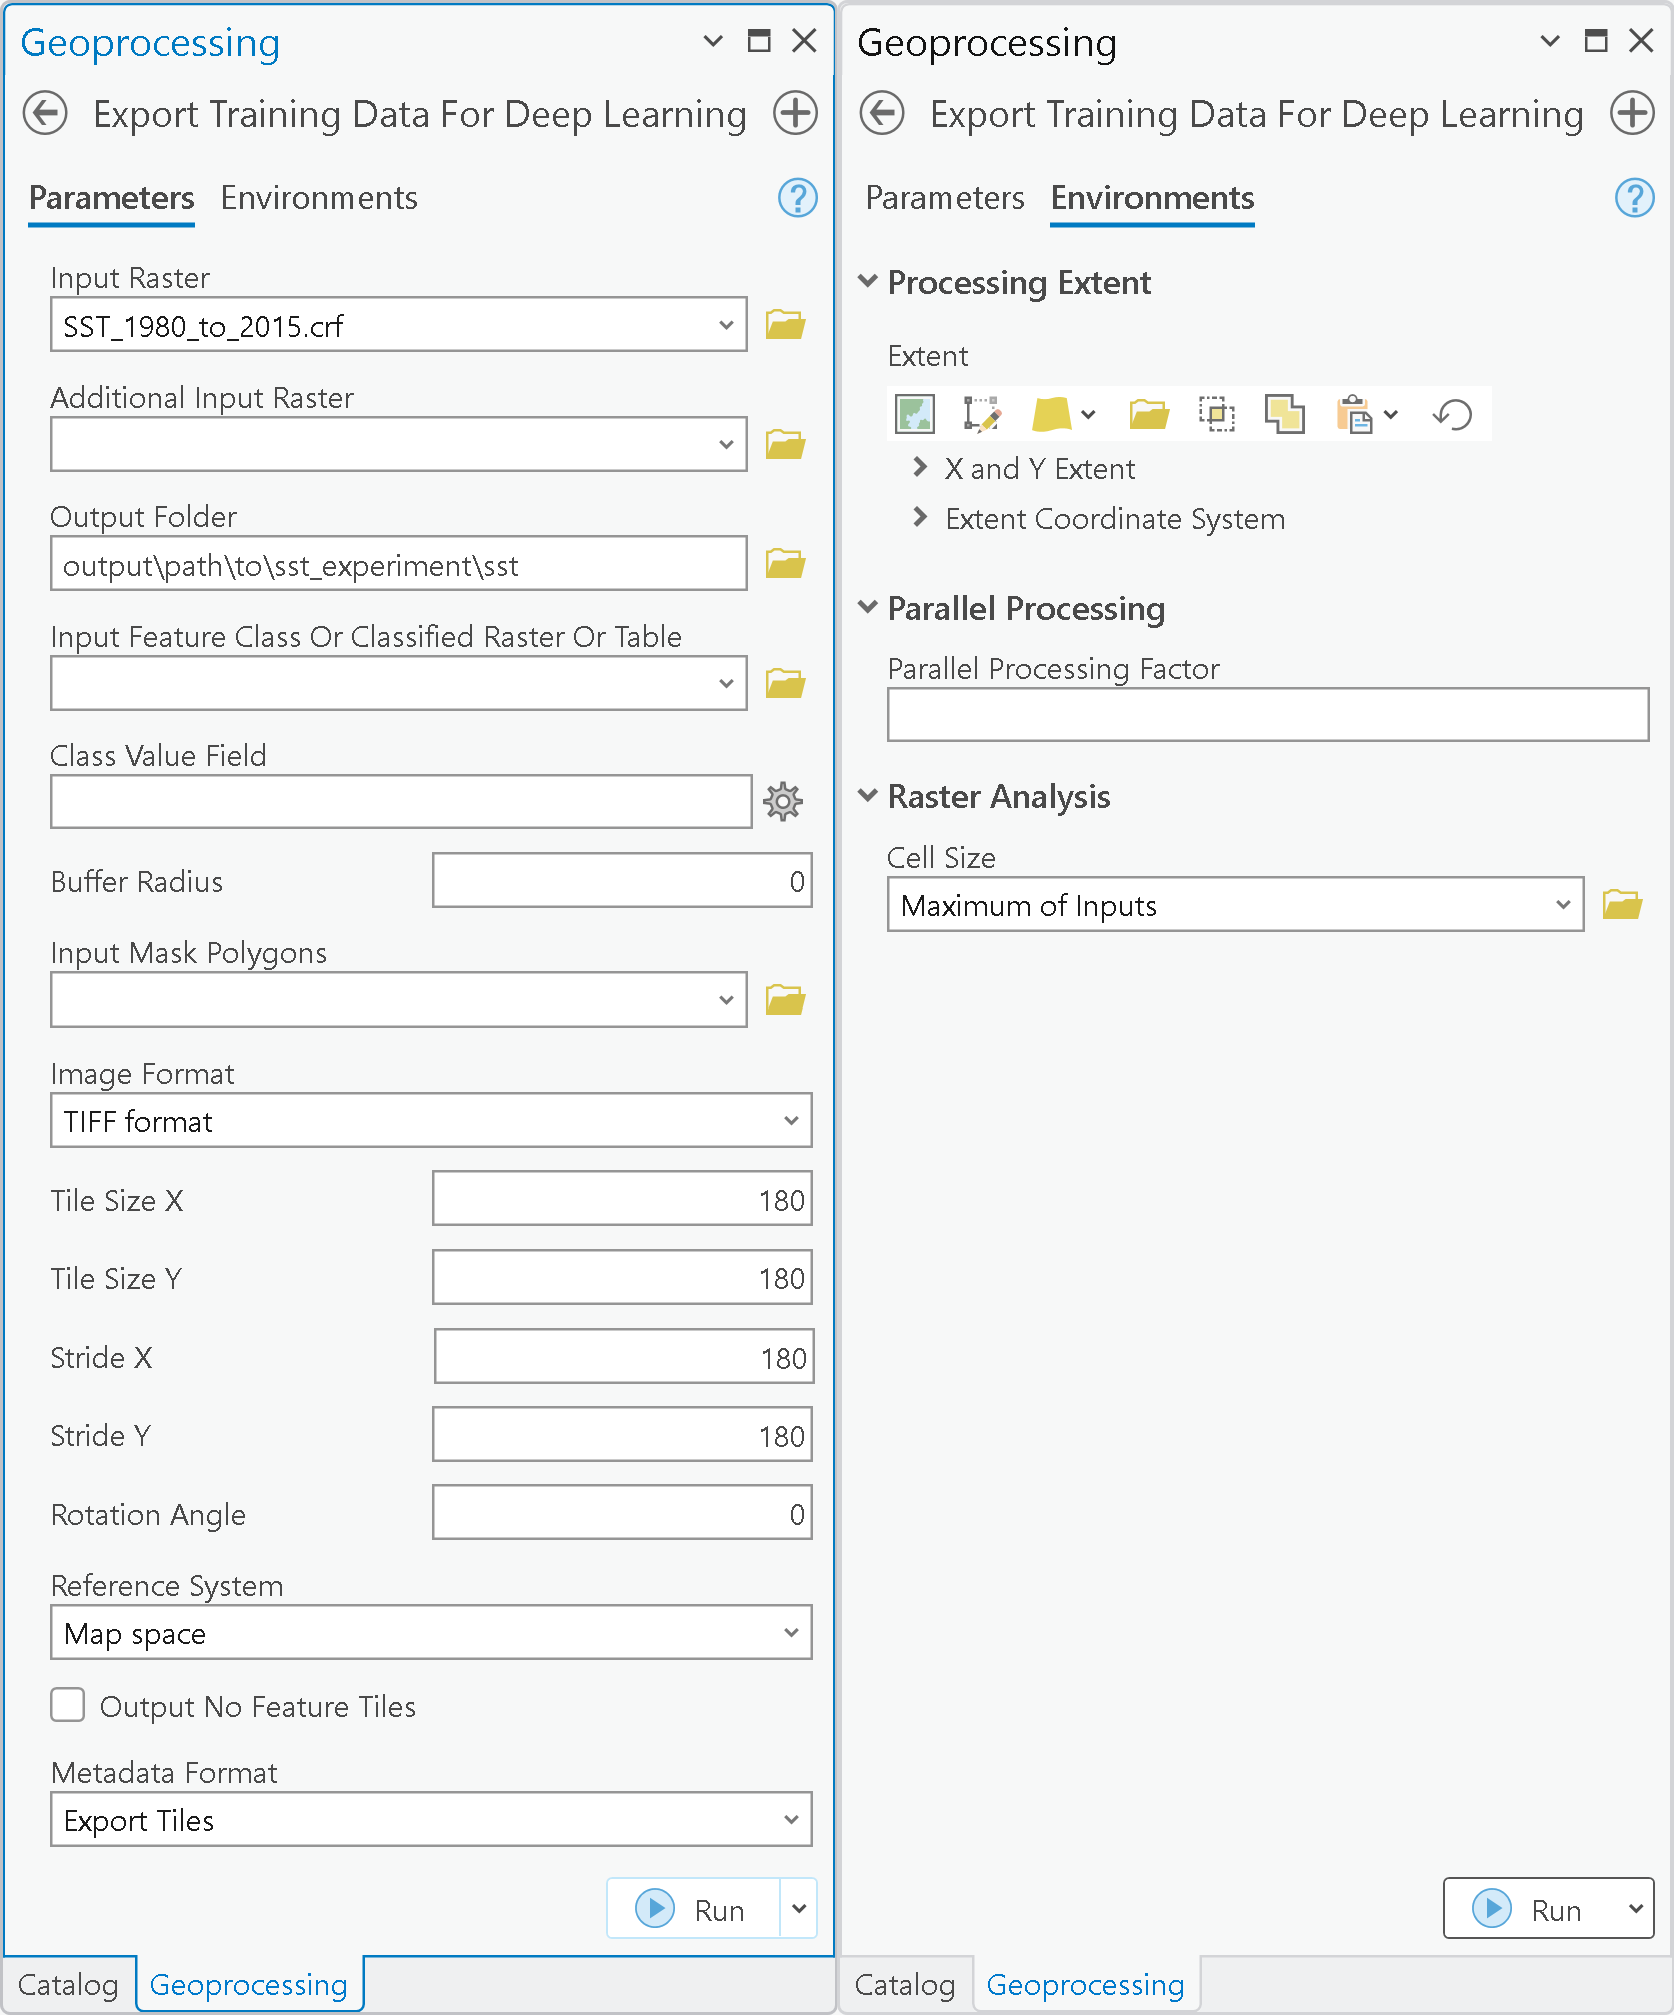

## Architecture

A model was needed that can learn from the variability of climate datasets with different dimensional variables. At the center, `ClimaX` is designed as a multi-dimensional image-to-image translation architecture, leveraging Vision Transformers (ViT) due to their ability to effectively tokenize the spatial nature of multiscale weather and climate data. This approach allows the architecture to extend tokenization across various multi-channel features. 

To tailor the ViT architecture for ClimaX, two crucial modifications are introduced: variable tokenization and variable aggregation. The modifications are briefly described in following sections.

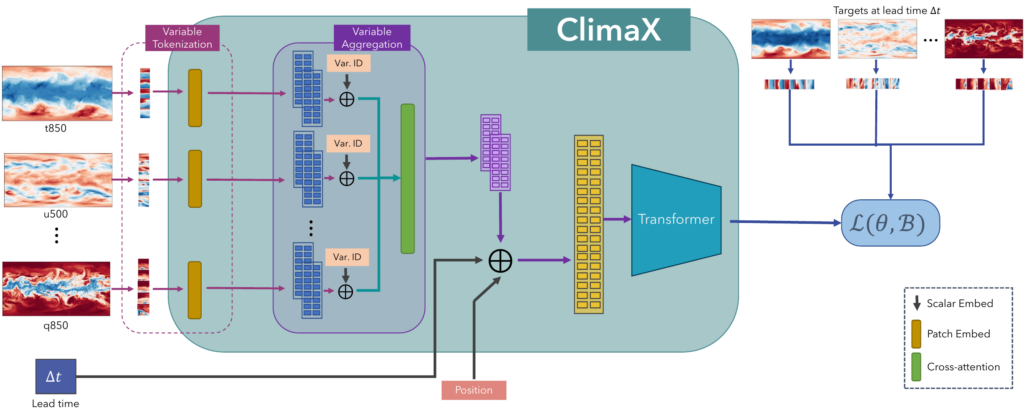

<center> Figure 2. In ClimaX architecture, variables are tokenized separately, aggregated, and combined with position and lead time embeddings before being fed into the ViT backbone [1]. </center> 

### Variable tokenization

The standard ViT tokenization for images involves dividing inputs into uniform patches and flattening them into vectors. However, this method is challenging for climate and weather data, where datasets can have varying physical variables. To address this, ClimaX introduces variable tokenization, treating each variable as a separate modality, allowing for more flexible training across diverse and irregular datasets.

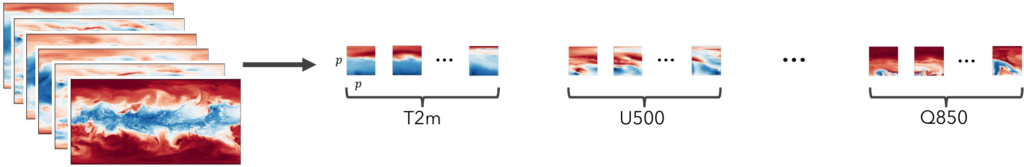

<center> Figure 3. Variable tokenization [1] </center> 

### Variable aggregation

Variable tokenization presents two key challenges: it generates sequences that scale linearly with the number of input variables, making them computationally expensive for ViT's self-attention layers, and it may include tokens representing variables with differing physical foundations. To address these issues, ClimaX introduces variable aggregation, a cross-attention mechanism that produces uniform embedding vectors for each spatial location.

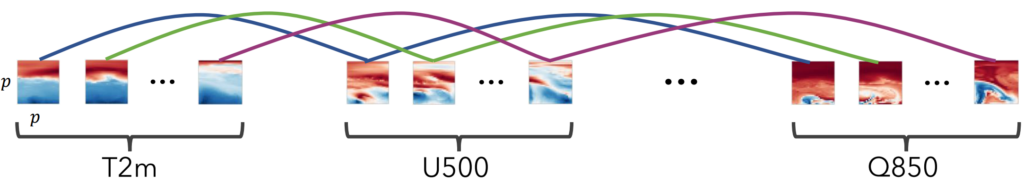

<center> Figure 4. Variable aggregation. A cross-attention operation for each  location [1]</center> 

## Implementation in `arcgis.learn`

For data preparation using the exported data, we use `prepare_data` available in `arcgis.learn`. We will specify the path to our training data and a few hyperparameters.

- `path` - Required string. path of the folder containing training data.
- `batch_size` - Required int. number of timesteps your model will train on each step inside an epoch.
- `forecast_timesteps` - Required int. default set to 1. how far the model should forecast into the future. A forecast timestep is the interval at which predictions are made, For example, If we have 8-hourly data point and we want to make a 8 hr, 16 hr, 32 hr forecast, forecast timesteps is set to 1, 2, 3 respectively and so on. In case of hourly and monthly data point, for forecasts of 1, 2, 3 hr/month, forecast timesteps is set to 1, 2, 3 respectively and so on.
- `hrs_each_step` - Optional int. default set to 1 (in hrs). number of hours in which data is collected. For example, if you have 8-hourly, hourly, monthly, daily then, hrs_each_step is to be set to 8, 1, 720 (30 days * 24), 24 hrs respectively.

for example if its monthly data. Hence, forecast_timesteps will be 1 month as we want monthly forecast and hrs_each_step will be 720, which is roughly 30 days * 24 hrs. 

`data = prepare_data(r"path/to/export/location", batch_size = 16, forecast_timesteps = 1, hrs_each_step = 720)`

By default, initialization of the `ClimaX` model object: a foundational model for weather and climate forecasting tasks as shown below:

`model = arcgis.learn.ClimaX(data, backbone)`

`backbone` - Optional string. pretrained foundational models as backbone. Compatible backbones: `5.625deg`, `1.40625deg`. Default set to `5.625deg`.

model parameters that can be passed using keyword arguments:

* `patch_size` - Optional int. Patch size for generating patch embeddings. Default: 4. In case of memory related issues, its suggested to increase path size in multiples of 2 i.e. 2, 4, 6 etc.
* `embed_dim` - Optional int. Dimension of embeddings. Default: 1024
* `depth` - Optional int. Depth of model. Default: 8
* `num_heads` - Optional int. Number of attention heads. Default: 16
* `mlp_ratio` - Optional float. Ratio of MLP. Default: 4.0
* `decoder_depth` - Optional int. Depth of decoder. Default: 2
* `drop_path` - Optional int. stochastic depth or randomly drops entire layers. Default: 0.1
* `drop_rate` - Optional int. randomly drops neurons. Default: 0.1
* `parallel_patch_embed` - Optional bol. parallel embdedding of patches. Default: True

Default values for optimal performance are set for model's hyperparmeters. 

Here, `data` is the object returned from `prepare_data` function.

For more information about the API, please go through the [API reference](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html).

## Inferencing in ArcGIS Pro

After training the ClimaX forecasting model and saving the weights via the API, the Classify Pixels Using Deep Learning tool available in both [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) and [ArcGIS Enterprise](https://www.esri.com/en-us/arcgis/products/arcgis-enterprise/overview)can be used for large-scale inferencing. The input raster for this tool is the one containing all variables at the final time step before forecasting. To extract the image of this time step from a multidimensional raster, you can use the [subset multidimensional raster](https://pro.arcgis.com/en/pro-app/latest/tool-reference/multidimension/subset-multidimensional-raster.htm) tool.

The input raster for this tool is the one containing all variables at the final time step before forecasting. To extract the image of this time step from a multidimensional raster, you can use the

- `number_of_time_steps_to_forecast` - the number of forecast periods is specified using this parameter, which defines the forecast duration. For instance, if your dataset consists of 8-hour intervals, setting the value to 5 would forecast 5 intervals (40 hours). In this case, with monthly data, setting the value to 120 would forecast 120 months or 10 years.

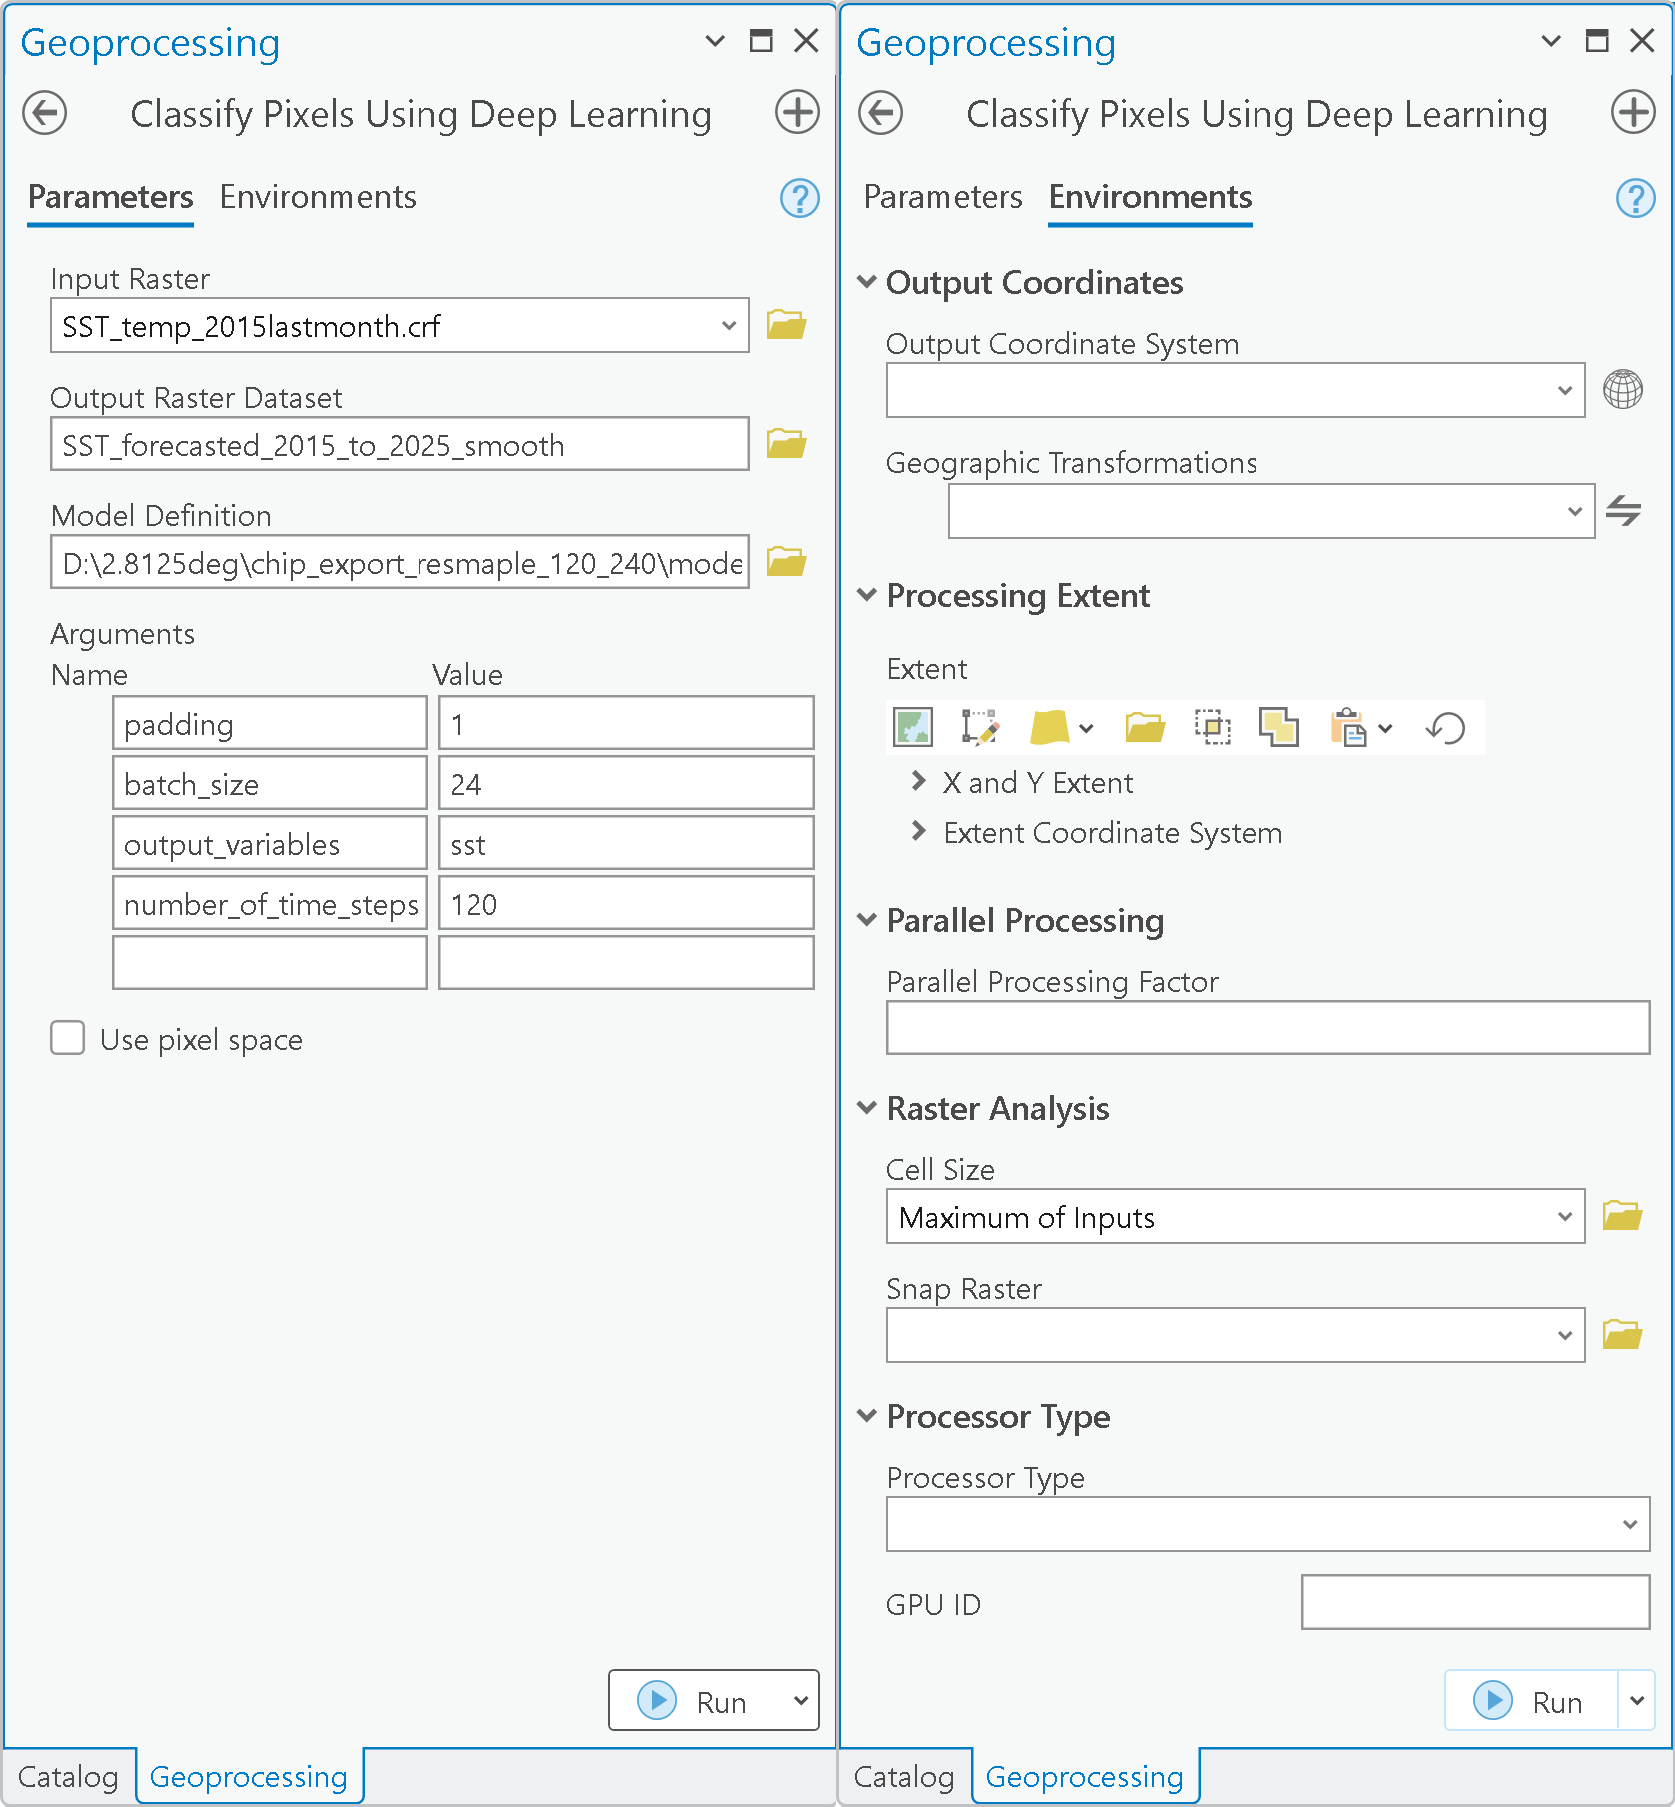

## References

- [1] Nguyen, Tung, Johannes Brandstetter, Ashish Kapoor, Jayesh K. Gupta, and Aditya Grover. "ClimaX: A foundation model for weather and climate." arXiv preprint arXiv:2301.10343 (2023).